In [1]:
import pandas as pd
df = pd.read_csv("Cleaned_Sent_Data_16MAR_v3.gz")

In [2]:
df = df.drop(['Unnamed: 0','index','_merge'],axis=1)

In [3]:
df

,Date,videoTitleSentimentScore_pos,videoTitleSentimentScore_neg,captionSentimentScore_pos,captionSentimentScore_neg,num_days_since_pub,viewcounts_weighted,like_count_weighted,like_dislike_ratio,weighted_like_dislike_ratio,like_dislike_ratio_by_viewcounts_weighted,percent_change,action
0,2020-10-02,0.081317,0.099751,0.102556,0.036249,17.925926,71814.282680,3271.401019,0.969752,0.969752,69921.826086,0.044362,buy
1,2020-10-03,0.059800,0.065880,0.116100,0.034660,35.600000,71921.099664,3523.220911,0.969585,0.969585,70150.404005,0.041791,buy
2,2020-10-04,0.066000,0.059480,0.110600,0.035320,21.680000,66084.953130,3030.285674,0.972772,0.972772,64444.365869,0.022541,hold
3,2020-10-05,0.071018,0.065469,0.110771,0.031495,19.829091,61208.718514,3150.355807,0.971021,0.971021,59725.066775,0.013192,hold
4,2020-10-06,0.066353,0.069018,0.110309,0.031280,19.432727,72276.063635,3948.601316,0.972598,0.972598,70807.388299,-0.022469,hold
...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,2021-02-15,0.034680,0.077251,0.107473,0.031818,115.607273,13347.728400,693.672590,0.956675,0.956675,12957.795705,-0.007472,hold
88,2021-02-16,0.040633,0.051960,0.102418,0.032844,120.298182,25551.254491,1678.468242,0.960266,0.960266,25040.842574,-0.012718,hold
89,2021-02-18,0.046834,0.058583,0.101794,0.032863,119.245714,16224.086329,939.047614,0.954441,0.954441,15837.504011,-0.042660,sell
90,2021-02-19,0.033890,0.069657,0.097573,0.031320,113.623333,19150.754564,1316.566845,0.958693,0.958693,18586.708998,-0.044162,sell


# EDA

    - Scaling Problem. captionSentimentScore_neg really small

In [ ]:
import seaborn as sns
sns.histplot(df,x='videoTitleSentimentScore_pos')

In [ ]:
sns.histplot(df,x='videoTitleSentimentScore_neg')

In [ ]:
sns.histplot(df,x='captionSentimentScore_pos')

In [ ]:
sns.histplot(df,x='captionSentimentScore_neg')

In [ ]:
sns.histplot(df,x='num_days_since_pub')

In [ ]:
sns.histplot(df,x='action')

# Data Scaling

In [6]:
X = df.iloc[:, 1:11].values
y = df.iloc[:, 12].astype('category').cat.codes.values

# One hot encoding --- skip for now
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
y = enc.fit_transform(y.reshape(-1,1)).toarray()

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [8]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [9]:
from sklearn.ensemble import RandomForestClassifier

regressor = RandomForestClassifier(n_estimators=10, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

In [10]:
y_pred

array([1, 0, 1, 1, 1, 0, 1, 0, 1, 2, 1, 1, 0, 0, 1, 1, 1, 0, 2],
      dtype=int8)

In [11]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[2 2 1]
 [2 8 0]
 [2 1 1]]
              precision    recall  f1-score   support

           0       0.33      0.40      0.36         5
           1       0.73      0.80      0.76        10
           2       0.50      0.25      0.33         4

    accuracy                           0.58        19
   macro avg       0.52      0.48      0.49        19
weighted avg       0.58      0.58      0.57        19

0.5789473684210527


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

# Import some data to play with
iris = datasets.load_iris()

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

# Add noisy features to make the problem harder
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,
                                                    random_state=0)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(RandomForestClassifier(n_estimators=10, random_state=0))
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

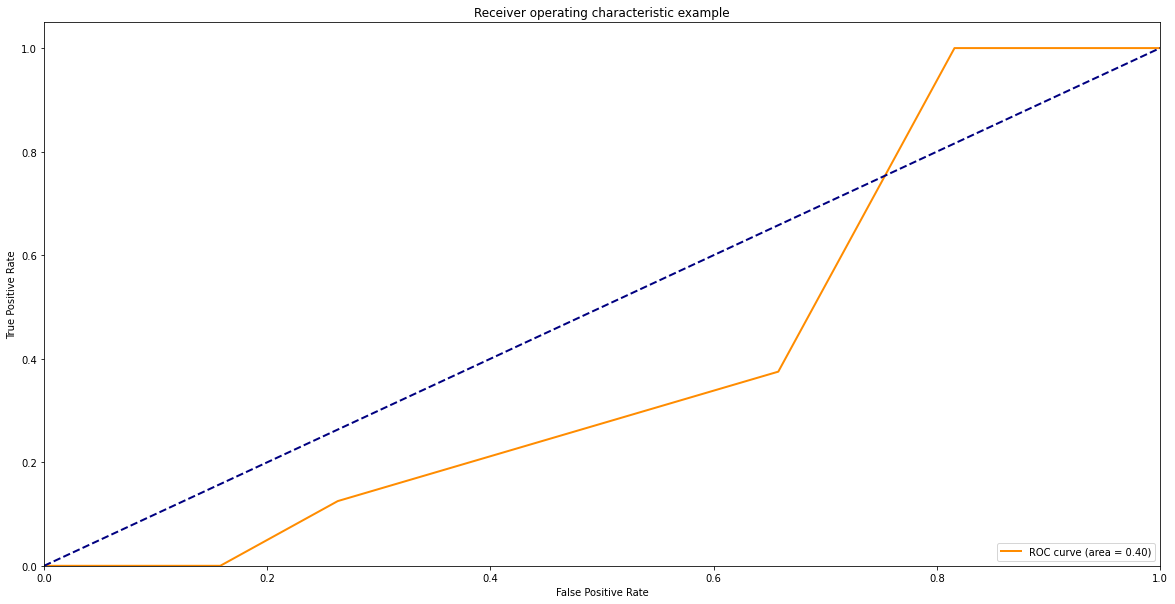

In [13]:
plt.figure(figsize=(20,10))
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


/Users/mymacbookpro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  import sys


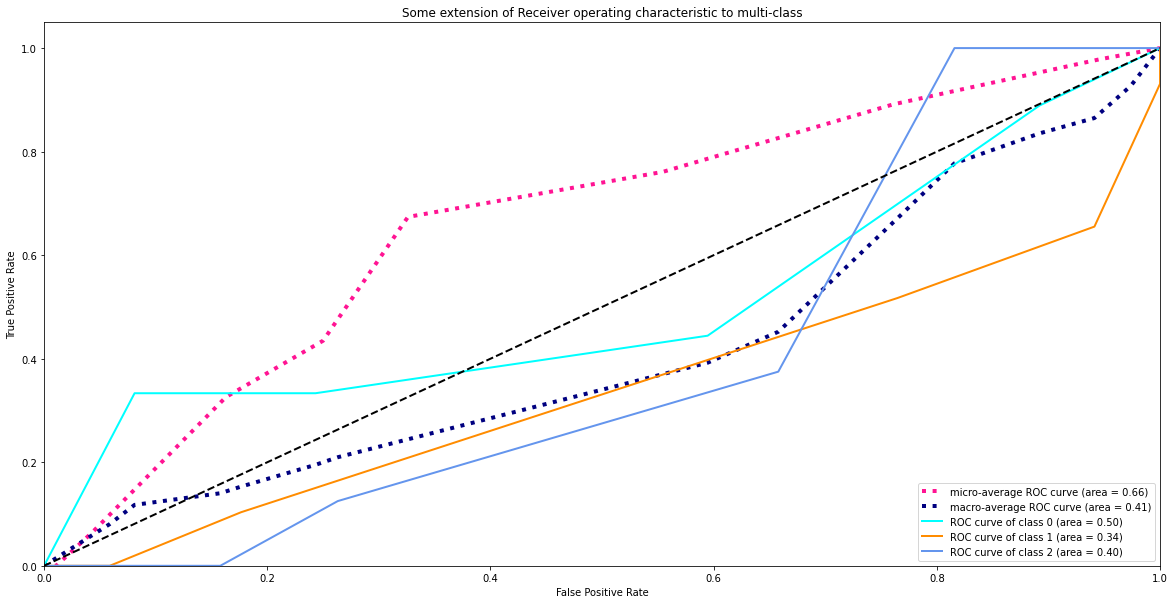

In [14]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(20,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()
